# Validation Analysis - Figures

In [1]:
SAVE_FIGS = True

In [1]:
import os

import pandas as pd
import geopandas as gpd
import numpy as np
import scipy
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.cm
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
REPO_ROOT = '/Users/rwegener/repos/chesapeake_mhw'

In [3]:
# MUR and Geopolar anomaly compared to in situ anomaly
# wq_sst = pd.read_csv('../data/AllTemps_SSTAnomaly.csv')
# 'Anomaly_values_satellite_cbp.csv'
# change to: 'sst_anomalies_satellites_cbp_stations.csv'
path = os.path.join(REPO_ROOT, 'data/processed', 'anomaly_values_satellites_CBPstations_filtered.csv')
wq_sst = pd.read_csv(path, parse_dates=[3])

In [5]:
wq_sst[wq_sst.SampleDate == '2003-01-15']

,MeasureAnomaly,Latitude,Longitude,SampleDate,geopolar_anom,mur_anom
0,-2.038462,39.44149,-76.02599,2003-01-15,-0.741257,-0.627800
297,-2.021429,39.34873,-76.17579,2003-01-15,-0.683519,-0.837237
597,-2.242857,39.24950,-76.24050,2003-01-15,-0.929541,-1.003538
12216,-0.905000,39.21309,-76.52254,2003-01-15,-1.623899,-1.429491


### delete later

In [5]:
june = wq_sst[(wq_sst.SampleDate.dt.month == 5)]

In [6]:
june.columns

Index(['MeasureAnomaly', 'Latitude', 'Longitude', 'SampleDate',
       'geopolar_anom', 'mur_anom'],
      dtype='object')

In [7]:
from scipy.stats import norm
import matplotlib.pyplot as plt

In [8]:
t_mean = june.MeasureAnomaly.mean()
t_std = june.MeasureAnomaly.std()
print(t_mean, t_std)

-0.00513661083959178 2.100028869301411


In [9]:
gp_mean = june.geopolar_anom.mean()
gp_std = june.geopolar_anom.std()
print(gp_mean, gp_std)

-0.5748039259107063 1.880753118734189


In [10]:
june.geopolar_anom.max(), june.geopolar_anom.min()

(4.670341245589725, -5.076474097467212)

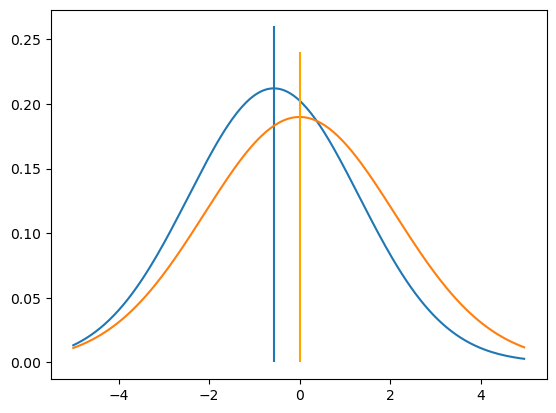

In [11]:
x = np.arange(-5, 5, 0.05)

plt.plot(x, norm.pdf(x, gp_mean, gp_std)) 
plt.vlines(gp_mean, 0, 0.26)
plt.plot(x, norm.pdf(x, t_mean, t_std)) 
plt.vlines(t_mean, 0, 0.24, color='orange')

In [12]:
wq_sst.groupby(wq_sst.SampleDate.dt.month)['geopolar_anom'].mean()

SampleDate
1    -0.042713
2    -0.249428
3    -0.517903
4    -0.203119
5    -0.574804
6     0.260379
7     0.082347
8    -0.104631
9    -0.135711
10   -0.255471
11    0.055401
12   -0.068739
Name: geopolar_anom, dtype: float64

<AxesSubplot: >

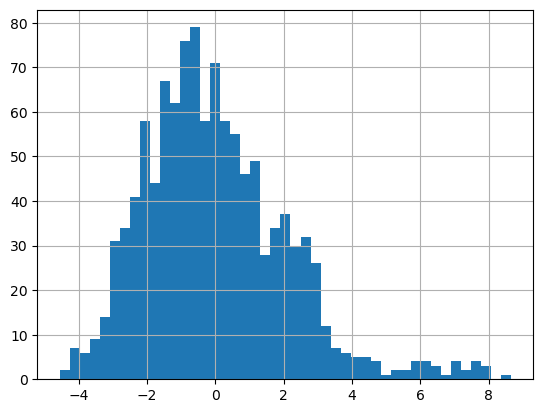

In [13]:
june.MeasureAnomaly.hist(bins=45)

## Mean Bias

In [4]:
wq_sst

,MeasureAnomaly,Latitude,Longitude,SampleDate,geopolar_anom,mur_anom
0,-2.038462,39.44149,-76.02599,2003-01-15,-0.741257,-0.627800
1,-2.838462,39.44149,-76.02599,2004-01-14,-0.954054,-0.414873
2,1.761538,39.44149,-76.02599,2005-01-13,0.379810,1.283643
3,1.461538,39.44149,-76.02599,2006-01-12,1.240869,-1.815707
4,2.161538,39.44149,-76.02599,2007-01-12,1.800897,3.213284
...,...,...,...,...,...,...
13483,-0.315625,38.84250,-76.53410,2018-02-15,0.428398,NaN
13484,-0.015625,38.84250,-76.53410,2019-02-11,-0.307749,NaN
13485,3.084375,38.84250,-76.53410,2020-02-13,1.321393,NaN
13486,-0.615625,38.84250,-76.53410,2021-02-08,0.745728,NaN


In [5]:
geopolar_error = (wq_sst.geopolar_anom - wq_sst.MeasureAnomaly).dropna()
print('Geo-Polar mean bias is', geopolar_error.sum() / len(geopolar_error))

Geo-Polar mean bias is -0.12123251399495667


In [6]:
mur_error = (wq_sst.mur_anom - wq_sst.MeasureAnomaly).dropna()
print('MUR mean bias is', mur_error.sum() / len(mur_error))

MUR mean bias is -0.15991037153837231


In [17]:
# Not yet computed
# ostia_error = (wq_sst.ostia - wq_sst.MeasureValue).dropna()
# print('OSTIA mean bias is', ostia_error.sum() / len(ostia_error))

OSTIA mean bias is -0.522069453819268


## Computing $R^2$ and creating scatter plot

### Preprocessing and $R^2$

In [7]:
mur_nonan = wq_sst[~wq_sst['mur_anom'].isnull()]
geop_nonan = wq_sst[~wq_sst['geopolar_anom'].isnull()]

In [8]:
# geop_nonan = geop_nonan[(geop_nonan.MeasureAnomaly > -5) & (geop_nonan.MeasureAnomaly < 5)]

In [9]:
x_geop = geop_nonan.MeasureAnomaly
y_geop = geop_nonan.geopolar_anom

x_mur = mur_nonan.MeasureAnomaly
y_mur = mur_nonan.mur_anom

In [10]:
mur_slope, mur_intercept, r_value, p_value, std_err = scipy.stats.linregress(x_mur, y_mur)

print('MUR: slope', mur_slope, 'intercept', mur_intercept, 'r squared', r_value**2, 'p_value', p_value)

MUR: slope 0.572366156657771 intercept -0.16016905699411196 r squared 0.30259680479483214 p_value 0.0


In [11]:
gp_slope, gp_intercept, r_value, p_value, std_err = scipy.stats.linregress(x_geop, y_geop)

print('GEOPOLAR: slope', gp_slope, 'intercept', gp_intercept, 'r squared', r_value**2, 'p_value', p_value)

GEOPOLAR: slope 0.541467239754602 intercept -0.12199579238121203 r squared 0.4408070540875558 p_value 0.0


In [12]:
xmin, xmax = pd.concat([x_geop, x_mur]).min(), pd.concat([x_geop, x_mur]).max()
ymin, ymax = pd.concat([y_geop, y_mur]).min(), pd.concat([y_geop, y_mur]).max()
print(xmin, xmax, ymin, ymax)

-8.331888888888887 8.650000000000002 -15.842631678427551 5.602590253276276


#### Moving away from OLS

[https://www.statsmodels.org/stable/rlm.html](https://www.statsmodels.org/stable/rlm.html)

References:
- SO [example](https://stackoverflow.com/questions/46606082/using-huber-scale-and-location-estimator-in-statsmodel)
- Penn State [course webpage](https://online.stat.psu.edu/stat501/lesson/t/t.1/t.1.1-robust-regression-methods)
- statsmodels [RLMdocs](https://www.statsmodels.org/stable/generated/statsmodels.robust.robust_linear_model.RLM.html)
- [graphs](https://www.statsmodels.org/stable/rlm_techn1.html) for the weight function
- SO [post](https://stackoverflow.com/questions/31655196/how-to-get-r-squared-for-robust-regression-rlm-in-statsmodels) arguing against R2 when using robust regression

In [13]:
import statsmodels.api as sm

In [14]:
res = sm.OLS(y_mur, x_mur).fit()
print(res.params)
print(res.bse)

MeasureAnomaly    0.572396
dtype: float64
MeasureAnomaly    0.007906
dtype: float64


In [15]:
# scipy.stats.linregress(x_mur, y_mur)

mur_model = sm.RLM(y_mur, sm.add_constant(x_mur), M=sm.robust.norms.TukeyBiweight())
mur_results = mur_model.fit()
print(mur_results.params)  # I think this is the slope
print(mur_results.bse)

const             0.041942
MeasureAnomaly    0.636557
dtype: float64
const             0.010937
MeasureAnomaly    0.006081
dtype: float64


In [16]:
rlm_slope_mur = mur_results.params.MeasureAnomaly
rlm_inter_mur = mur_results.params.const

In [17]:
rlm_inter_mur

0.04194187452706398

In [18]:
geop_model = sm.RLM(y_geop, sm.add_constant(x_geop), M=sm.robust.norms.TukeyBiweight())
geop_results = geop_model.fit()
print(geop_results.params)  # I think this is the slope
print(geop_results.bse)

const            -0.096677
MeasureAnomaly    0.585041
dtype: float64
const             0.009119
MeasureAnomaly    0.005044
dtype: float64


In [19]:
rlm_slope_geop = geop_results.params.MeasureAnomaly
rlm_inter_geop = geop_results.params.const

In [20]:
rlm_slope_geop

0.5850409870872461

In [21]:
rlm_inter_geop

-0.09667739185230578

In [25]:
geop_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:          geopolar_anom   No. Observations:                12511
Model:                            RLM   Df Residuals:                    12509
Method:                          IRLS   Df Model:                            1
Norm:                   TukeyBiweight                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 12 Aug 2024                                         
Time:                        08:23:02                                         
No. Iterations:                    19                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0967      0.009    -10.602      0.000      -0.115      -0.079
MeasureAnomaly     0.5850      0.005    115.993      0.000       0.575       0.595
==================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

In [26]:
def mx_plus_b(x, slope, intercept):
    return slope * x + intercept

Note: It is possible I am missing values on this graph because `mincnt` I believe is only showing bins where there are at least 2 values. So maybe we are dropping lots of values?

In [27]:
geop_nonan

,MeasureAnomaly,Latitude,Longitude,SampleDate,geopolar_anom,mur_anom
0,-2.038462,39.44149,-76.02599,2003-01-15,-0.741257,-0.627800
1,-2.838462,39.44149,-76.02599,2004-01-14,-0.954054,-0.414873
2,1.761538,39.44149,-76.02599,2005-01-13,0.379810,1.283643
3,1.461538,39.44149,-76.02599,2006-01-12,1.240869,-1.815707
4,2.161538,39.44149,-76.02599,2007-01-12,1.800897,3.213284
...,...,...,...,...,...,...
13483,-0.315625,38.84250,-76.53410,2018-02-15,0.428398,NaN
13484,-0.015625,38.84250,-76.53410,2019-02-11,-0.307749,NaN
13485,3.084375,38.84250,-76.53410,2020-02-13,1.321393,NaN
13486,-0.615625,38.84250,-76.53410,2021-02-08,0.745728,NaN


## RMSE

In [25]:
N = len(wq_sst[~wq_sst['geopolar_diff'].isnull()])

rmse_geopolar = np.sqrt((wq_sst['geopolar_diff']**2).sum() / N)
print('rmse geopolar: ', rmse_geopolar)

N = len(wq_sst[~wq_sst['mur_diff'].isnull()])

rmse_mur = np.sqrt((wq_sst['mur_diff']**2).sum() / N)
print('rmse mur: ', rmse_mur)

rmse geopolar:  1.384820063049322
rmse mur:  1.7491546648385357


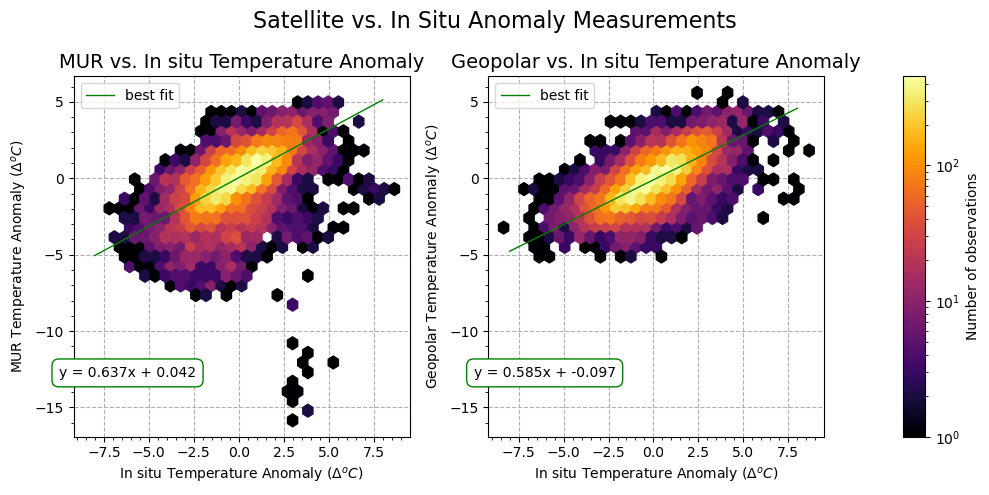

In [30]:
gridspec = {'width_ratios': [1.5, 1.5, 0.1]}
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5), gridspec_kw=gridspec)
fig.suptitle('Satellite vs. In Situ Anomaly Measurements', size=16)

bbox_props = {'boxstyle': 'round', 'facecolor': 'white',
             'pad': 0.5, 'edgecolor': 'green'}

# my_cmap = matplotlib.cm.get_cmap('magma_r')
# my_cmap.set_under('w')

# gridsize used to be 30, 30
mur_plot = ax1.hexbin(x_mur, y_mur, gridsize=30, bins='log', cmap='inferno', 
                      extent=(xmin, xmax, ymin, ymax)) # mincnt=1)
# plot the line of linear fit
# ax1.plot([-8, 8], [mx_plus_b(-8, mur_slope, mur_intercept), 
#                      mx_plus_b(8, mur_slope, mur_intercept)], 
#          color='green', label='linear fit', linewidth=0.8)
ax1.plot([-8, 8], [mx_plus_b(-8, rlm_slope_mur, rlm_inter_mur), 
                     mx_plus_b(8, rlm_slope_mur, rlm_inter_mur)], 
         color='green', label='best fit', linewidth=1)
ax1.set_ylabel('MUR Temperature Anomaly ($\Delta^oC$)')
ax1.set_title('MUR vs. In situ Temperature Anomaly', size=14)
ax1.text(-10, -13, 'y = {m}x + {b}'.format(m=rlm_slope_mur.round(3), 
                                    b=rlm_inter_mur.round(3)), bbox=bbox_props)


geop_plot = ax2.hexbin(x_geop, y_geop, gridsize=30, bins='log', cmap='inferno',
                      extent=(xmin, xmax, ymin, ymax))  # , mincnt=1)
# plot the line of linear fit
# ax2.plot([-8, 8], [mx_plus_b(-8, gp_slope, gp_intercept), 
#                      mx_plus_b(8, gp_slope, gp_intercept)], 
#          color='green', label='linear fit', linewidth=0.8)
ax2.plot([-8, 8], [mx_plus_b(-8, rlm_slope_geop, rlm_inter_geop), 
                     mx_plus_b(8, rlm_slope_geop, rlm_inter_geop)], 
         color='green', label='best fit', linewidth=1)
ax2.set_ylabel('Geopolar Temperature Anomaly ($\Delta^oC$)')
ax2.set_title('Geopolar vs. In situ Temperature Anomaly', size=14)
ax2.text(-10, -13, 'y = {m}x + {b}'.format(m=rlm_slope_geop.round(3), 
                                    b=rlm_inter_geop.round(3)), bbox=bbox_props)


# Standardize axes settings
for ax in (ax1, ax2):
    # plot and label the 1:1 line
    # ax.plot([-10, 10], [-10, 10], color='blue', label='1:1 line', linewidth=0.8)
    ax.legend(loc="upper left")
    # standardize the axes
    # ax.set_xlim([-16, 16])
    # ax.set_ylim([-12, 8])
    # label the x axis
    ax.set_xlabel('In situ Temperature Anomaly ($\Delta^oC$)')
    ax.minorticks_on()
    # add gridlines
    ax.set_axisbelow(True)
    ax.grid(linestyle='--', linewidth=0.8)

# Add shared colorbar
cb = fig.colorbar(geop_plot, cax=ax3)
cb.set_label('Number of observations')

# Turn back on for SST Values
fig.tight_layout()

if SAVE_FIGS:
    plt.savefig(os.path.join(REPO_ROOT, 'figures/validation_analysis/satellite_validation_anomaly_hexplot.jpeg'), 
                bbox_inches='tight', dpi=700)


### Preprocessing

In [23]:
wq_sst['geopolar_diff'] = wq_sst['geopolar_anom'] - wq_sst['MeasureAnomaly']
wq_sst['mur_diff'] = wq_sst['mur_anom'] - wq_sst['MeasureAnomaly']

In [24]:
temps_mean = wq_sst.groupby(['Latitude', 'Longitude']).mean()
temps_mean = temps_mean.reset_index()

/var/folders/nb/y7dp0ct55_58hrhrhlz5vbkm0000gn/T/ipykernel_49496/1720388.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temps_mean = wq_sst.groupby(['Latitude', 'Longitude']).mean()


## Error Histogram

**TODO:** What is the point of the plot? Is it to show that the distribtuion is just a bit wider/narrow in each satellite? Or is it to show that one outlier?

In [37]:
wq_sst_mur = wq_sst[~wq_sst.mur_diff.isnull()]
wq_sst_gp = wq_sst[~wq_sst.geopolar_diff.isnull()]

In [38]:
mur_mean, mur_std = wq_sst_mur.mur_diff.mean(), wq_sst_mur.mur_diff.std()
gp_mean, gp_std = wq_sst_gp.geopolar_diff.mean(), wq_sst_gp.geopolar_diff.std()

In [39]:
mur_skew, mur_kurtosis = scipy.stats.skew(wq_sst_mur.mur_diff), scipy.stats.kurtosis(wq_sst_mur.mur_diff)
gp_skew, gp_kurtosis = scipy.stats.skew(wq_sst_gp.geopolar_diff), scipy.stats.kurtosis(wq_sst_gp.geopolar_diff)

In [40]:
print('mur skew / kurtosis: ', mur_skew, mur_kurtosis)
print('geopolar skew / kurtosis: ', gp_skew, gp_kurtosis)

mur skew / kurtosis:  -1.6990625220800284 11.304740678182444
geopolar skew / kurtosis:  -0.25358373705171716 2.3489464673784655


In [41]:
mur_mean, mur_std

(-0.15991037153837231, 1.7419010588567387)

In [42]:
gp_mean, gp_std

(-0.12123251399495667, 1.3795584094994455)

**TODO** Can I justify this times 2000 thing?

In [43]:
# Normal Distributions
x_norm = np.linspace(-10, 10, 100)
mur_norm = [stats.norm.pdf(x, mur_mean, mur_std)*2000 for x in x_norm]
gp_norm = [stats.norm.pdf(x, gp_mean, gp_std)*2000 for x in x_norm]
# stats.norm.pdf(x, mu, sigma)

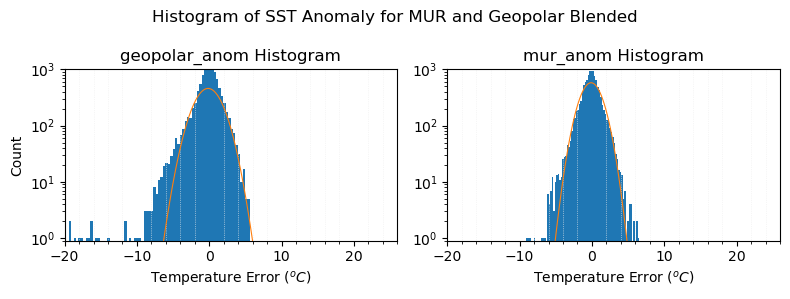

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_size_inches(8, 3)
fig.suptitle('Histogram of SST Anomaly for MUR and Geopolar Blended')

wq_sst_mur.geopolar_diff.hist(ax = ax2, bins=75)
ax2.set_title('mur_anom' + ' Histogram')
# Plot normal curve
ax2.plot(x_norm, gp_norm, linewidth=0.8)
ax2.set_yscale('log')

wq_sst_gp.mur_diff.hist(ax = ax1, bins=75, log=True)
ax1.set_title('geopolar_anom' + ' Histogram')
ax1.set_ylabel('Count')
ax1.plot(x_norm, mur_norm, linewidth=0.8)
ax1.set_yscale('log')

for ax in (ax1, ax2):
    # label x axis
    ax.set_xlabel('Temperature Error ($^oC$)')
    # standardize axes
    # ax.set_xlim([-8, 23])
    ax.set_ylim([0.9, 1000])
    ax.set_xlim([-20, 26])
    # ax.set_ylim([0.8, 10000])
    # WHAT TO DO ABOUT GRIDLINES
    # add minor ticks
    # ax.xaxis.grid(which='major', color='#DDDDDD', linewidth=0.8)
    # # Show the minor grid as well. Style it in very light gray as a thin,
    # # dotted line.
    ax.xaxis.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.grid(False)
    # ax.axvline(0, color='black')

plt.tight_layout()
if SAVE_FIGS:
    plt.savefig(os.path.join(REPO_ROOT, 'figures', 'validation_analysis/errors_histogram.png'), 
                dpi=400, bbox_inches='tight')

## Spatial Plots

**TODO**: figure out if there is a way to improve the resolution of the coastline, so it doesn't look like there are datapoints being taken on land.

**TODO**: Awkward spacing

In [45]:
temps_mean_gpd = gpd.GeoDataFrame(
    temps_mean, geometry=gpd.points_from_xy(temps_mean['Longitude'], temps_mean['Latitude']), 
    crs='epsg:4326'
)

Below: There are 49 anomaly validation stations spread across the bay

In [46]:
# temps_mean_gpd.groupby(['Latitude', 'Longitude']).groups

<AxesSubplot: >

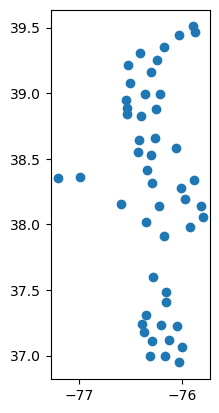

In [47]:
temps_mean_gpd.plot()

### Long Term Trend by location

In [48]:
wq_sst.SampleDate

0       2003-01-15
1       2004-01-14
2       2005-01-13
3       2006-01-12
4       2007-01-12
           ...    
13483   2018-02-15
13484   2019-02-11
13485   2020-02-13
13486   2021-02-08
13487   2022-02-09
Name: SampleDate, Length: 13488, dtype: datetime64[ns]

In [49]:
def get_slope(df):
    '''
    Slope of the long term trend in geopolar error.
    Units unknown a.t.m.
    '''
    # print(len(df))
    x = df.SampleDate.apply(lambda x: x.toordinal())
    y = df.geopolar_diff
    # Slope of long term trend
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    # Multiply by 365 so units are degrees / year not degrees / day
    df['slope'] = slope * 365
    if p_value >= 0.05:
        df['slope'] = np.nan
    # Mean
    df['mean'] = df.geopolar_diff.mean()
    # STD
    df['std'] = df.geopolar_diff.std()
    # Skew
    df['skew'] = scipy.stats.skew(df.geopolar_diff)
    # kurtosis
    df['kurt'] = scipy.stats.kurtosis(df.geopolar_diff)
    # 95th percentile
    df['95th'] = df.geopolar_diff.quantile(0.95)
    return df

In [50]:
slopes = wq_sst.groupby(['Latitude', 'Longitude'], group_keys=True).apply(get_slope)

In [51]:
slopes

MeasureAnomaly  Latitude  Longitude SampleDate  \
Latitude Longitude                                                        
36.94737 -76.03494 5555       -1.118667  36.94737  -76.03494 2003-01-13   
                   5556       -1.518667  36.94737  -76.03494 2004-01-13   
                   5557        1.061333  36.94737  -76.03494 2005-01-12   
                   5558        0.521333  36.94737  -76.03494 2006-01-10   
                   5559        5.051333  36.94737  -76.03494 2007-01-09   
...                                 ...       ...        ...        ...   
39.50873 -75.89783 7760       -0.535714  39.50873  -75.89783 2017-01-19   
                   7761       -1.835714  39.50873  -75.89783 2018-01-24   
                   7762       -0.735714  39.50873  -75.89783 2019-01-16   
                   7763        2.164286  39.50873  -75.89783 2020-01-15   
                   7764       -0.335714  39.50873  -75.89783 2021-01-14   

                         geopolar_anom  mur_anom  geopolar_diff  mur_diff  \
Latitude Longitude                                                          
36.94737 -76.03494 5555      -1.429380  0.582486      -0.310714  1.701153   
                   5556      -1.759397  1.411496      -0.240731  2.930163   
                   5557      -0.412114  0.156735      -1.473448 -0.904598   
                   5558      -0.006400  0.036607      -0.527733 -0.484726   
                   5559       4.043071  4.222503      -1.008262 -0.828831   
...                                ...       ...            ...       ...   
39.50873 -75.89783 7760            NaN  0.880917            NaN  1.416632   
                   7761            NaN -1.552718            NaN  0.282997   
                   7762            NaN -0.179778            NaN  0.555936   
                   7763            NaN  2.992138            NaN  0.827853   
                   7764            NaN  0.513448            NaN  0.849163   

                         slope      mean       std      skew      kurt  \
Latitude Longitude                                                       
36.94737 -76.03494 5555    NaN -0.125905  1.197151  0.384603  1.459485   
                   5556    NaN -0.125905  1.197151  0.384603  1.459485   
                   5557    NaN -0.125905  1.197151  0.384603  1.459485   
                   5558    NaN -0.125905  1.197151  0.384603  1.459485   
                   5559    NaN -0.125905  1.197151  0.384603  1.459485   
...                        ...       ...       ...       ...       ...   
39.50873 -75.89783 7760    NaN       NaN       NaN       NaN       NaN   
                   7761    NaN       NaN       NaN       NaN       NaN   
                   7762    NaN       NaN       NaN       NaN       NaN   
                   7763    NaN       NaN       NaN       NaN       NaN   
                   7764    NaN       NaN       NaN       NaN       NaN   

                             95th  
Latitude Longitude                 
36.94737 -76.03494 5555  1.999505  
                   5556  1.999505  
                   5557  1.999505  
                   5558  1.999505  
                   5559  1.999505  
...                           ...  
39.50873 -75.89783 7760       NaN  
                   7761       NaN  
                   7762       NaN  
                   7763       NaN  
                   7764       NaN  

[13488 rows x 14 columns]

In [52]:
stats_gpd = gpd.GeoDataFrame(
    slopes, geometry=gpd.points_from_xy(slopes.Longitude, slopes.Latitude), crs="EPSG:4326"
)

In [53]:
std = wq_sst.groupby(['Latitude', 'Longitude', wq_sst.SampleDate.dt.month]).std(numeric_only=True) \
.groupby(['Latitude', 'Longitude']).mean().reset_index()

In [54]:
std_gpd = gpd.GeoDataFrame(
    std, geometry=gpd.points_from_xy(std.Longitude, std.Latitude), crs="EPSG:4326"
)

In [55]:
print('Geopolar max/min:', temps_mean_gpd.geopolar_diff.max(), temps_mean_gpd.geopolar_diff.min(), 
     temps_mean_gpd.geopolar_diff.median(), temps_mean_gpd.geopolar_diff.std())
# print('MUR max/min:', temps_mean_gpd.mur_diff.max(), temps_mean_gpd.mur_diff.min(),
#      temps_mean_gpd.mur_diff.median(), temps_mean_gpd.mur_diff.std())

Geopolar max/min: 0.05209254332606683 -0.4055115107842069 -0.12748729888938945 0.09608947886393399


In [56]:
vmin, vmax = -1, 1

In [57]:
norm = matplotlib.colors.SymLogNorm(linthresh=1, vmin=-5, vmax=5, base=10)

<AxesSubplot: >

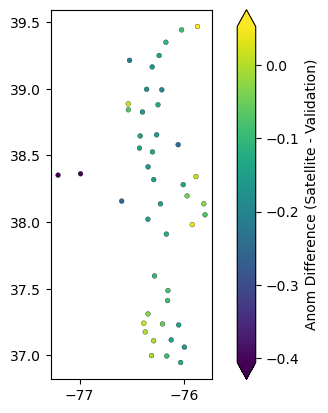

In [58]:
temps_mean_gpd.plot(column='geopolar_diff', markersize=12, legend=True, 
                    legend_kwds={'label': "Anom Difference (Satellite - Validation)", 'extend': 'both'}, 
                    edgecolor='black', linewidth=0.2)

In [59]:
temps_mean_gpd.geopolar_diff.max()

0.05209254332606683

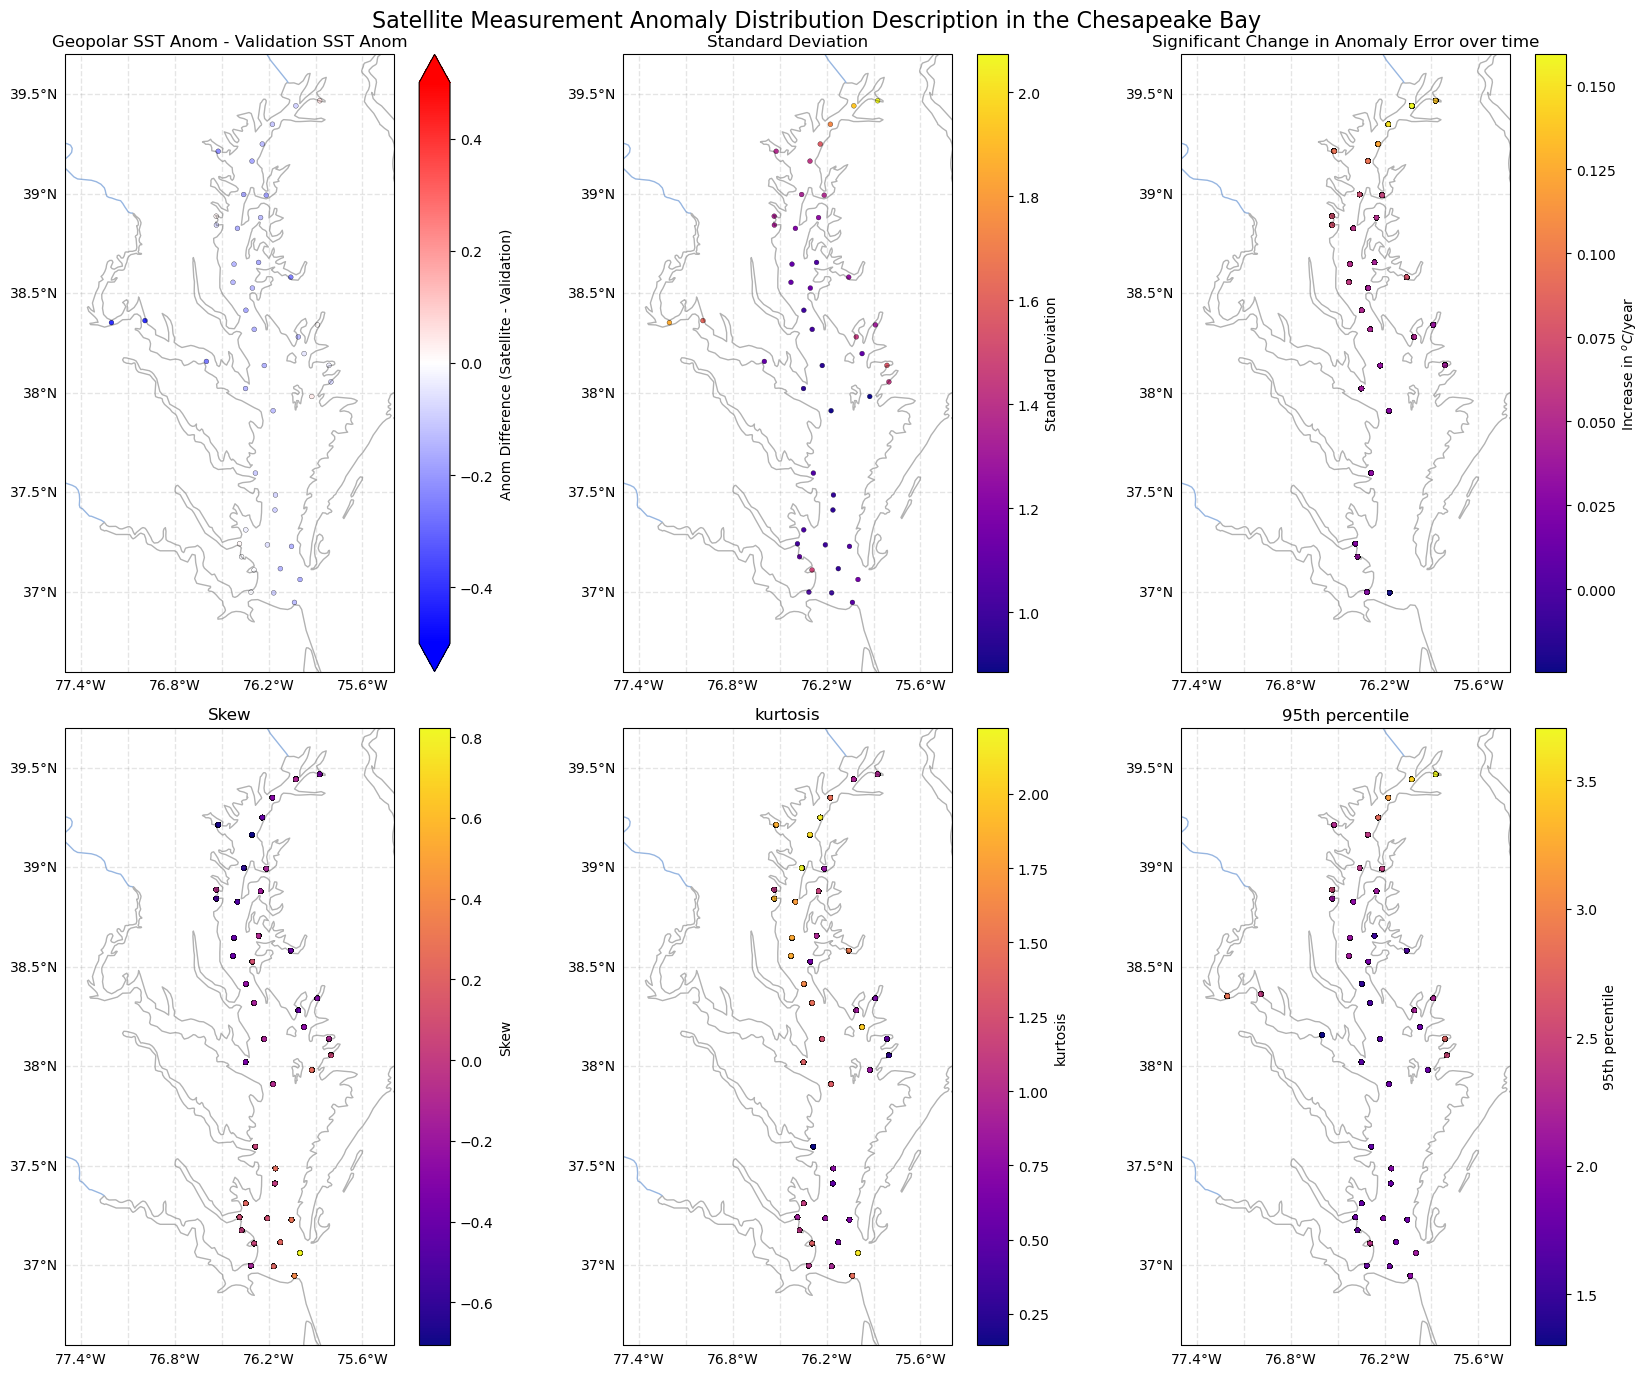

In [60]:
fig, axes = plt.subplots(2, 3, subplot_kw={'projection': ccrs.PlateCarree()})

fig.set_size_inches(17, 14)
# fig.tight_layout()
fig.suptitle('Satellite Measurement Anomaly Distribution Description in the Chesapeake Bay', size=16)
# fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

# my_cmap = matplotlib.cm.get_cmap('viridis')
# my_cmap.set_bad('black')

for ax in axes.flatten():
    # Add background features
    ax.add_feature(cfeature.COASTLINE, alpha=0.3)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.RIVERS)
    # ax.coastlines()

    ax.set_extent([-77.5, -75.4, 36.6, 39.7])

    # Add and format gridlines. Remove top and right labels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.2, linestyle='--')
    gl.top_labels, gl.right_labels = False, False

# Add mean error
temps_mean_gpd.plot(ax=axes[0, 0], column='geopolar_diff', markersize=12, cmap='bwr', legend=True, 
                    legend_kwds={'label': "Anom Difference (Satellite - Validation)", 'extend': 'both'}, 
                    vmin=-0.5, vmax=0.5, edgecolor='black', linewidth=0.2)
axes[0, 0].set_title('Geopolar SST Anom - Validation SST Anom', size=12)

# Standard Deviation
std_gpd.plot(ax=axes[0, 1], column='geopolar_diff', markersize=12, cmap='plasma',
                legend=True,
                    legend_kwds={'label': "Standard Deviation"}, 
                    edgecolor='black', linewidth=0.2)
axes[0, 1].set_title('Standard Deviation', size=12)

# Add long term trend slope
# Can't get pandas to show nan values. Maybe set to 0 then change colormap?
stats_gpd.plot(ax=axes[0, 2], column='slope', markersize=12, cmap='plasma',
                legend=True,
                    legend_kwds={'label': "Increase in $^oC$/year"}, 
                    edgecolor='black', linewidth=0.2)
axes[0, 2].set_title('Significant Change in Anomaly Error over time', size=12)


# Skew
stats_gpd.plot(ax=axes[1, 0], column='skew', markersize=12, cmap='plasma',
                legend=True,
                    legend_kwds={'label': "Skew"}, 
                    edgecolor='black', linewidth=0.2)
axes[1, 0].set_title('Skew', size=12)

# Kurtosis
stats_gpd.plot(ax=axes[1, 1], column='kurt', markersize=12, cmap='plasma',
                legend=True,
                    legend_kwds={'label': "kurtosis"}, 
                    edgecolor='black', linewidth=0.2)
axes[1, 1].set_title('kurtosis', size=12)

# 95th Percentile
stats_gpd.plot(ax=axes[1, 2], column='95th', markersize=12, cmap='plasma',
                legend=True,
                    legend_kwds={'label': "95th percentile"}, 
                    edgecolor='black', linewidth=0.2)
axes[1, 2].set_title('95th percentile', size=12)


plt.tight_layout()

# save
if SAVE_FIGS:
    plt.savefig(os.path.join(REPO_ROOT, 'figures', 'validation_analysis/map_distribution_statistics.png'), 
                dpi=400, bbox_inches='tight')

Significant Time increases by spatial location

In [61]:
def trend_calc(df):
    '''
    When grouping by lat/long aggregate the anomalies by sorting in time and calculating
    returning True/False based on if there is a statistically significant change in 
    MeasureAnomaly over time
    '''
    df = df.sort_values('SampleDate')
    df = df[~df.geopolar_diff.isnull()]
    # print('IS NULL?', df.SampleDate.apply(lambda x: x.toordinal()))
    x = df.SampleDate.apply(lambda x: x.toordinal())
    y = df.geopolar_diff.values
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    print(slope, intercept, r_value, p_value, std_err)
    plt.plot(x, y)
    plt.show()
    return slope

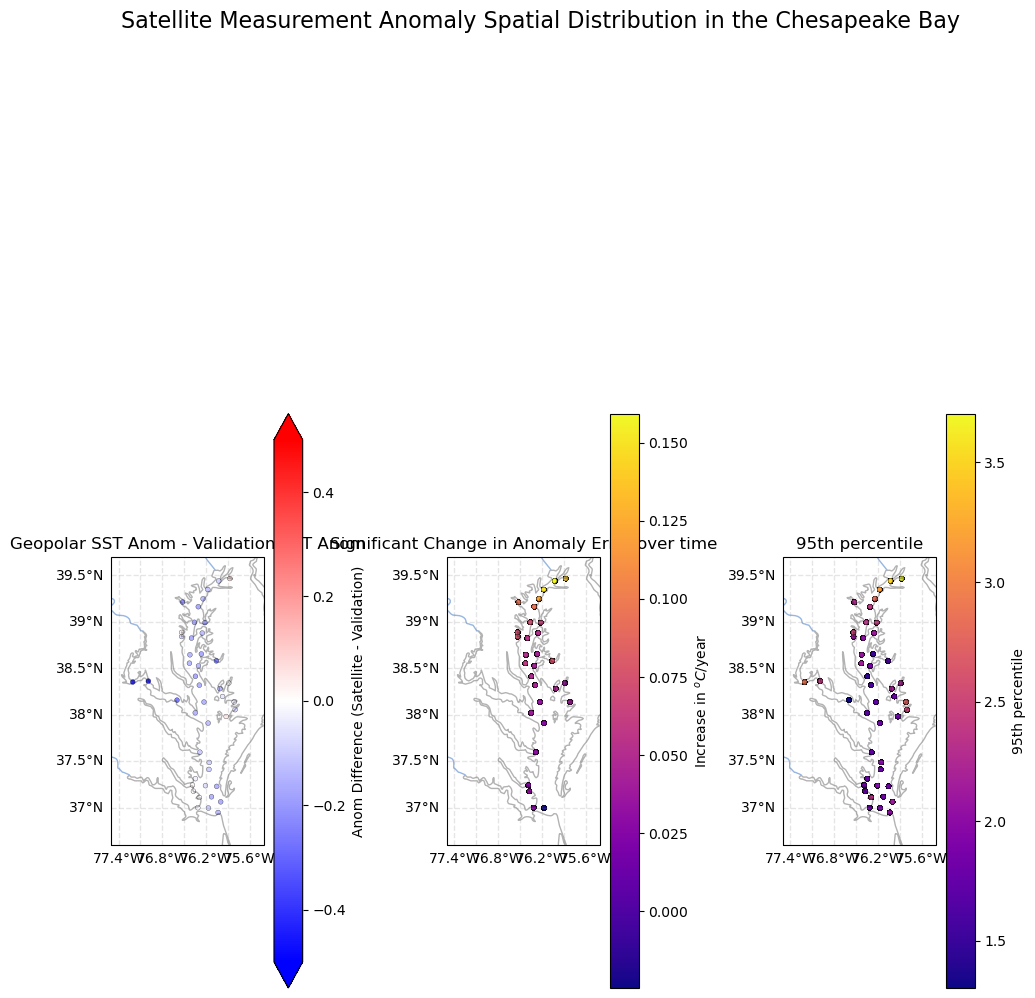

In [62]:
fig, axes = plt.subplots(1, 3, subplot_kw={'projection': ccrs.PlateCarree()})

fig.set_size_inches(10, 14)
# fig.tight_layout()
fig.suptitle('Satellite Measurement Anomaly Spatial Distribution in the Chesapeake Bay', size=16)
# fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

# my_cmap = matplotlib.cm.get_cmap('viridis')
# my_cmap.set_bad('black')

for ax in axes.flatten():
    # Add background features
    ax.add_feature(cfeature.COASTLINE, alpha=0.3)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.RIVERS)

    ax.set_extent([-77.5, -75.4, 36.6, 39.7])

    # Add and format gridlines. Remove top and right labels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.2, linestyle='--')
    gl.top_labels, gl.right_labels = False, False
    # ax.set_aspecxt('equal', 'box')

# Add mean error
temps_mean_gpd.plot(ax=axes[0], column='geopolar_diff', markersize=12, cmap='bwr', legend=True, 
                    legend_kwds={'label': "Anom Difference (Satellite - Validation)", 'extend': 'both'}, 
                    vmin=-0.5, vmax=0.5, edgecolor='black', linewidth=0.2)
axes[0].set_title('Geopolar SST Anom - Validation SST Anom', size=12)

# Add long term trend slope
# Can't get pandas to show nan values. Maybe set to 0 then change colormap?
stats_gpd.plot(ax=axes[1], column='slope', markersize=12, cmap='plasma',
                legend=True,
                    legend_kwds={'label': "Increase in $^oC$/year"}, 
                    edgecolor='black', linewidth=0.2)
axes[1].set_title('Significant Change in Anomaly Error over time', size=12)

# 95th Percentile
stats_gpd.plot(ax=axes[2], column='95th', markersize=12, cmap='plasma',
                legend=True,
                    legend_kwds={'label': "95th percentile"}, 
                    edgecolor='black', linewidth=0.2)
axes[2].set_title('95th percentile', size=12)


plt.tight_layout()

# save
if SAVE_FIGS:
    plt.savefig(os.path.join(REPO_ROOT, 'figures', 'validation_analysis/map_distribution_statistics.png'), 
                dpi=400, bbox_inches='tight')

In [63]:
stats_gpd

MeasureAnomaly  Latitude  Longitude SampleDate  \
Latitude Longitude                                                        
36.94737 -76.03494 5555       -1.118667  36.94737  -76.03494 2003-01-13   
                   5556       -1.518667  36.94737  -76.03494 2004-01-13   
                   5557        1.061333  36.94737  -76.03494 2005-01-12   
                   5558        0.521333  36.94737  -76.03494 2006-01-10   
                   5559        5.051333  36.94737  -76.03494 2007-01-09   
...                                 ...       ...        ...        ...   
39.50873 -75.89783 7760       -0.535714  39.50873  -75.89783 2017-01-19   
                   7761       -1.835714  39.50873  -75.89783 2018-01-24   
                   7762       -0.735714  39.50873  -75.89783 2019-01-16   
                   7763        2.164286  39.50873  -75.89783 2020-01-15   
                   7764       -0.335714  39.50873  -75.89783 2021-01-14   

                         geopolar_anom  mur_anom  geopolar_diff  mur_diff  \
Latitude Longitude                                                          
36.94737 -76.03494 5555      -1.429380  0.582486      -0.310714  1.701153   
                   5556      -1.759397  1.411496      -0.240731  2.930163   
                   5557      -0.412114  0.156735      -1.473448 -0.904598   
                   5558      -0.006400  0.036607      -0.527733 -0.484726   
                   5559       4.043071  4.222503      -1.008262 -0.828831   
...                                ...       ...            ...       ...   
39.50873 -75.89783 7760            NaN  0.880917            NaN  1.416632   
                   7761            NaN -1.552718            NaN  0.282997   
                   7762            NaN -0.179778            NaN  0.555936   
                   7763            NaN  2.992138            NaN  0.827853   
                   7764            NaN  0.513448            NaN  0.849163   

                         slope      mean       std      skew      kurt  \
Latitude Longitude                                                       
36.94737 -76.03494 5555    NaN -0.125905  1.197151  0.384603  1.459485   
                   5556    NaN -0.125905  1.197151  0.384603  1.459485   
                   5557    NaN -0.125905  1.197151  0.384603  1.459485   
                   5558    NaN -0.125905  1.197151  0.384603  1.459485   
                   5559    NaN -0.125905  1.197151  0.384603  1.459485   
...                        ...       ...       ...       ...       ...   
39.50873 -75.89783 7760    NaN       NaN       NaN       NaN       NaN   
                   7761    NaN       NaN       NaN       NaN       NaN   
                   7762    NaN       NaN       NaN       NaN       NaN   
                   7763    NaN       NaN       NaN       NaN       NaN   
                   7764    NaN       NaN       NaN       NaN       NaN   

                             95th                    geometry  
Latitude Longitude                                             
36.94737 -76.03494 5555  1.999505  POINT (-76.03494 36.94737)  
                   5556  1.999505  POINT (-76.03494 36.94737)  
                   5557  1.999505  POINT (-76.03494 36.94737)  
                   5558  1.999505  POINT (-76.03494 36.94737)  
                   5559  1.999505  POINT (-76.03494 36.94737)  
...                           ...                         ...  
39.50873 -75.89783 7760       NaN  POINT (-75.89783 39.50873)  
                   7761       NaN  POINT (-75.89783 39.50873)  
                   7762       NaN  POINT (-75.89783 39.50873)  
                   7763       NaN  POINT (-75.89783 39.50873)  
                   7764       NaN  POINT (-75.89783 39.50873)  

[13488 rows x 15 columns]

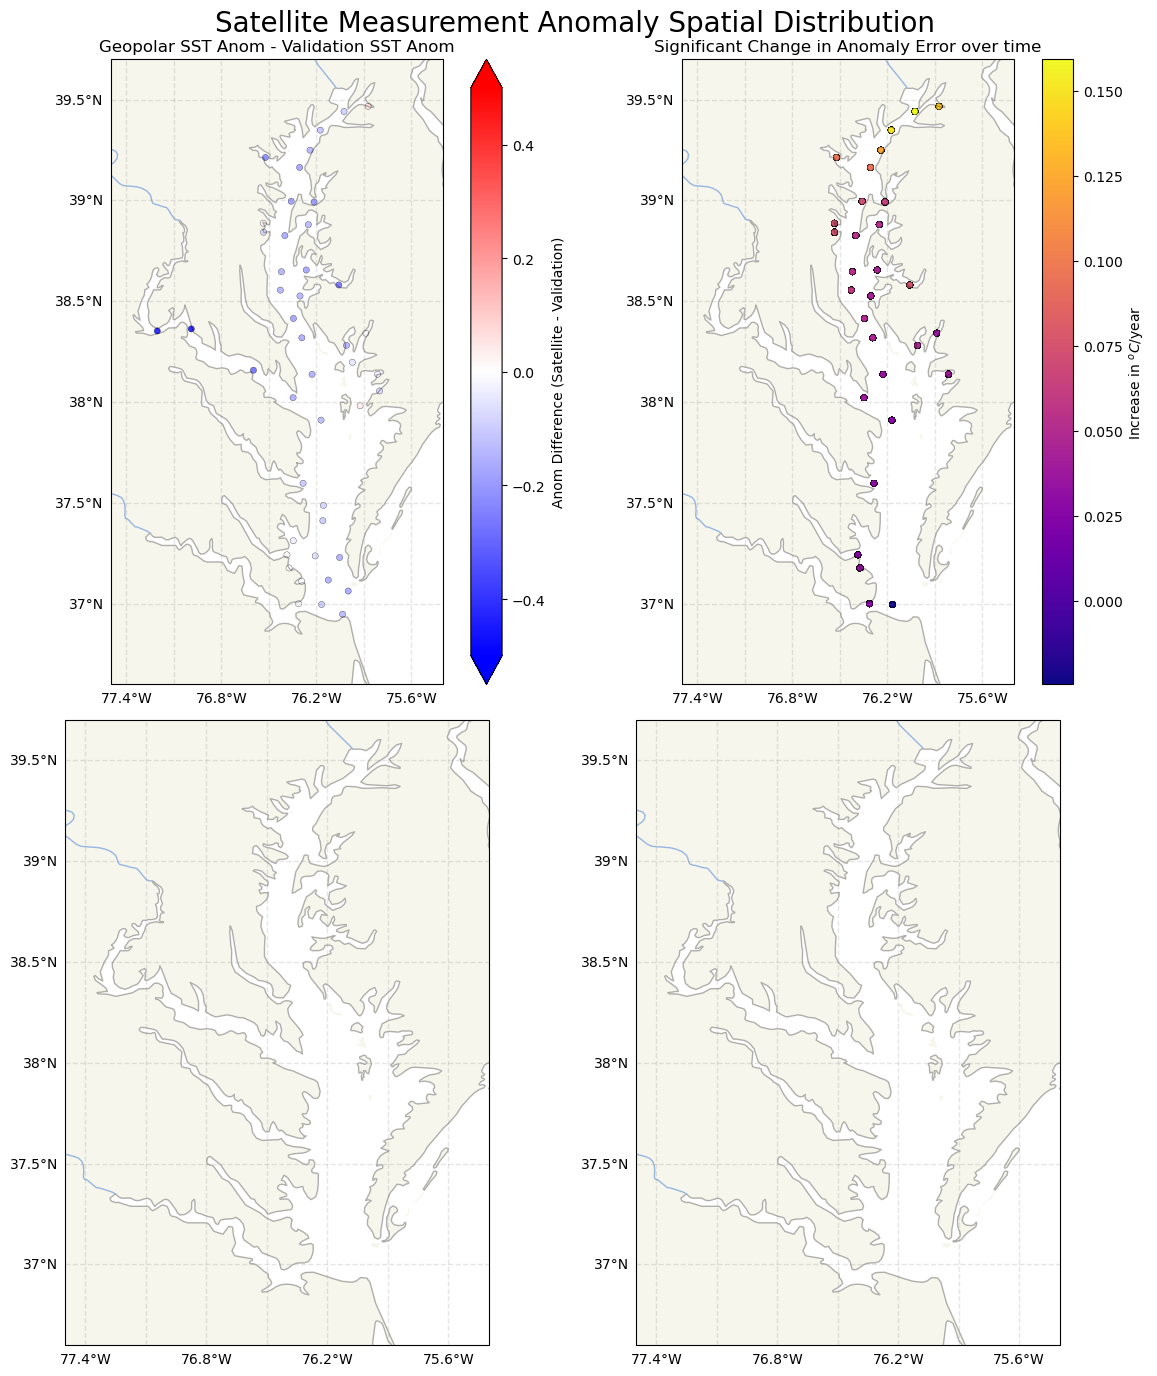

In [64]:
fig, axes = plt.subplots(2, 2, subplot_kw={'projection': ccrs.PlateCarree()})

fig.set_size_inches(12, 14)
# fig.tight_layout()
fig.suptitle('Satellite Measurement Anomaly Spatial Distribution', size=20)
# fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

# my_cmap = matplotlib.cm.get_cmap('viridis')
# my_cmap.set_bad('black')

for ax in axes.flatten():
    # Add background features
    ax.add_feature(cfeature.COASTLINE, alpha=0.3)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)
    # ax.coastlines()
    # Put a background image on for nice sea rendering.
    # ax.stock_img()

    ax.set_extent([-77.5, -75.4, 36.6, 39.7])

    # Add and format gridlines. Remove top and right labels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.2, linestyle='--')
    gl.top_labels, gl.right_labels = False, False

# Add mean error
temps_mean_gpd.plot(ax=axes[0, 0], column='geopolar_diff', markersize=20, cmap='bwr', legend=True, 
                    legend_kwds={'label': "Anom Difference (Satellite - Validation)", 'extend': 'both'}, 
                    vmin=-0.5, vmax=0.5, edgecolor='black', linewidth=0.2)
axes[0, 0].set_title('Geopolar SST Anom - Validation SST Anom', size=12)

# Standard Deviation
# std_gpd.plot(ax=axes[0, 1], column='geopolar_diff', markersize=12, cmap='plasma',
#                 legend=True,
#                     legend_kwds={'label': "Standard Deviation"}, 
#                     edgecolor='black', linewidth=0.2)
# axes[0, 1].set_title('Standard Deviation', size=12)

# Add long term trend slope
# Can't get pandas to show nan values. Maybe set to 0 then change colormap?
stats_gpd.plot(ax=axes[0, 1], column='slope', markersize=20, cmap='plasma',
                legend=True,
                    legend_kwds={'label': "Increase in $^oC$/year"}, 
                    edgecolor='black', linewidth=0.2)
axes[0, 1].set_title('Significant Change in Anomaly Error over time', size=12)

# Skew
# stats_gpd.plot(ax=axes[1, 0], column='skew', markersize=12, cmap='plasma',
#                 legend=True,
#                     legend_kwds={'label': "Skew"}, 
#                     edgecolor='black', linewidth=0.2)
# axes[1, 0].set_title('Skew', size=12)

# Kurtosis
# stats_gpd.plot(ax=axes[1, 1], column='kurt', markersize=12, cmap='plasma',
#                 legend=True,
#                     legend_kwds={'label': "kurtosis"}, 
#                     edgecolor='black', linewidth=0.2)
# axes[1, 1].set_title('kurtosis', size=12)

# 95th Percentile
# stats_gpd.plot(ax=axes[0, 2], column='95th', markersize=20, cmap='plasma',
#                 legend=True,
#                     legend_kwds={'label': "95th percentile"}, 
#                     edgecolor='black', linewidth=0.2)
# axes[0, 2].set_title('95th percentile', size=12)


plt.tight_layout()

# save
if SAVE_FIGS:
    plt.savefig(os.path.join(REPO_ROOT, 'figures', 'validation_analysis/map_distribution_statistics_shorter.png'), 
                dpi=400, bbox_inches='tight')

In [65]:
stats_gpd

MeasureAnomaly  Latitude  Longitude SampleDate  \
Latitude Longitude                                                        
36.94737 -76.03494 5555       -1.118667  36.94737  -76.03494 2003-01-13   
                   5556       -1.518667  36.94737  -76.03494 2004-01-13   
                   5557        1.061333  36.94737  -76.03494 2005-01-12   
                   5558        0.521333  36.94737  -76.03494 2006-01-10   
                   5559        5.051333  36.94737  -76.03494 2007-01-09   
...                                 ...       ...        ...        ...   
39.50873 -75.89783 7760       -0.535714  39.50873  -75.89783 2017-01-19   
                   7761       -1.835714  39.50873  -75.89783 2018-01-24   
                   7762       -0.735714  39.50873  -75.89783 2019-01-16   
                   7763        2.164286  39.50873  -75.89783 2020-01-15   
                   7764       -0.335714  39.50873  -75.89783 2021-01-14   

                         geopolar_anom  mur_anom  geopolar_diff  mur_diff  \
Latitude Longitude                                                          
36.94737 -76.03494 5555      -1.429380  0.582486      -0.310714  1.701153   
                   5556      -1.759397  1.411496      -0.240731  2.930163   
                   5557      -0.412114  0.156735      -1.473448 -0.904598   
                   5558      -0.006400  0.036607      -0.527733 -0.484726   
                   5559       4.043071  4.222503      -1.008262 -0.828831   
...                                ...       ...            ...       ...   
39.50873 -75.89783 7760            NaN  0.880917            NaN  1.416632   
                   7761            NaN -1.552718            NaN  0.282997   
                   7762            NaN -0.179778            NaN  0.555936   
                   7763            NaN  2.992138            NaN  0.827853   
                   7764            NaN  0.513448            NaN  0.849163   

                         slope      mean       std      skew      kurt  \
Latitude Longitude                                                       
36.94737 -76.03494 5555    NaN -0.125905  1.197151  0.384603  1.459485   
                   5556    NaN -0.125905  1.197151  0.384603  1.459485   
                   5557    NaN -0.125905  1.197151  0.384603  1.459485   
                   5558    NaN -0.125905  1.197151  0.384603  1.459485   
                   5559    NaN -0.125905  1.197151  0.384603  1.459485   
...                        ...       ...       ...       ...       ...   
39.50873 -75.89783 7760    NaN       NaN       NaN       NaN       NaN   
                   7761    NaN       NaN       NaN       NaN       NaN   
                   7762    NaN       NaN       NaN       NaN       NaN   
                   7763    NaN       NaN       NaN       NaN       NaN   
                   7764    NaN       NaN       NaN       NaN       NaN   

                             95th                    geometry  
Latitude Longitude                                             
36.94737 -76.03494 5555  1.999505  POINT (-76.03494 36.94737)  
                   5556  1.999505  POINT (-76.03494 36.94737)  
                   5557  1.999505  POINT (-76.03494 36.94737)  
                   5558  1.999505  POINT (-76.03494 36.94737)  
                   5559  1.999505  POINT (-76.03494 36.94737)  
...                           ...                         ...  
39.50873 -75.89783 7760       NaN  POINT (-75.89783 39.50873)  
                   7761       NaN  POINT (-75.89783 39.50873)  
                   7762       NaN  POINT (-75.89783 39.50873)  
                   7763       NaN  POINT (-75.89783 39.50873)  
                   7764       NaN  POINT (-75.89783 39.50873)  

[13488 rows x 15 columns]

In [66]:
test_xr = stats_gpd.drop(['Latitude', 'Longitude'], axis=1).to_xarray()

In [67]:
test_xr.MeasureAnomaly.isel({'level_2':0})

<xarray.DataArray 'MeasureAnomaly' (Latitude: 49, Longitude: 49)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * Latitude   (Latitude) float64 36.95 37.0 37.0 37.06 ... 39.44 39.47 39.51
  * Longitude  (Longitude) float64 -77.21 -76.99 -76.6 ... -75.87 -75.81 -75.8
    level_2    int64 0

## THIS ONE GETS USED

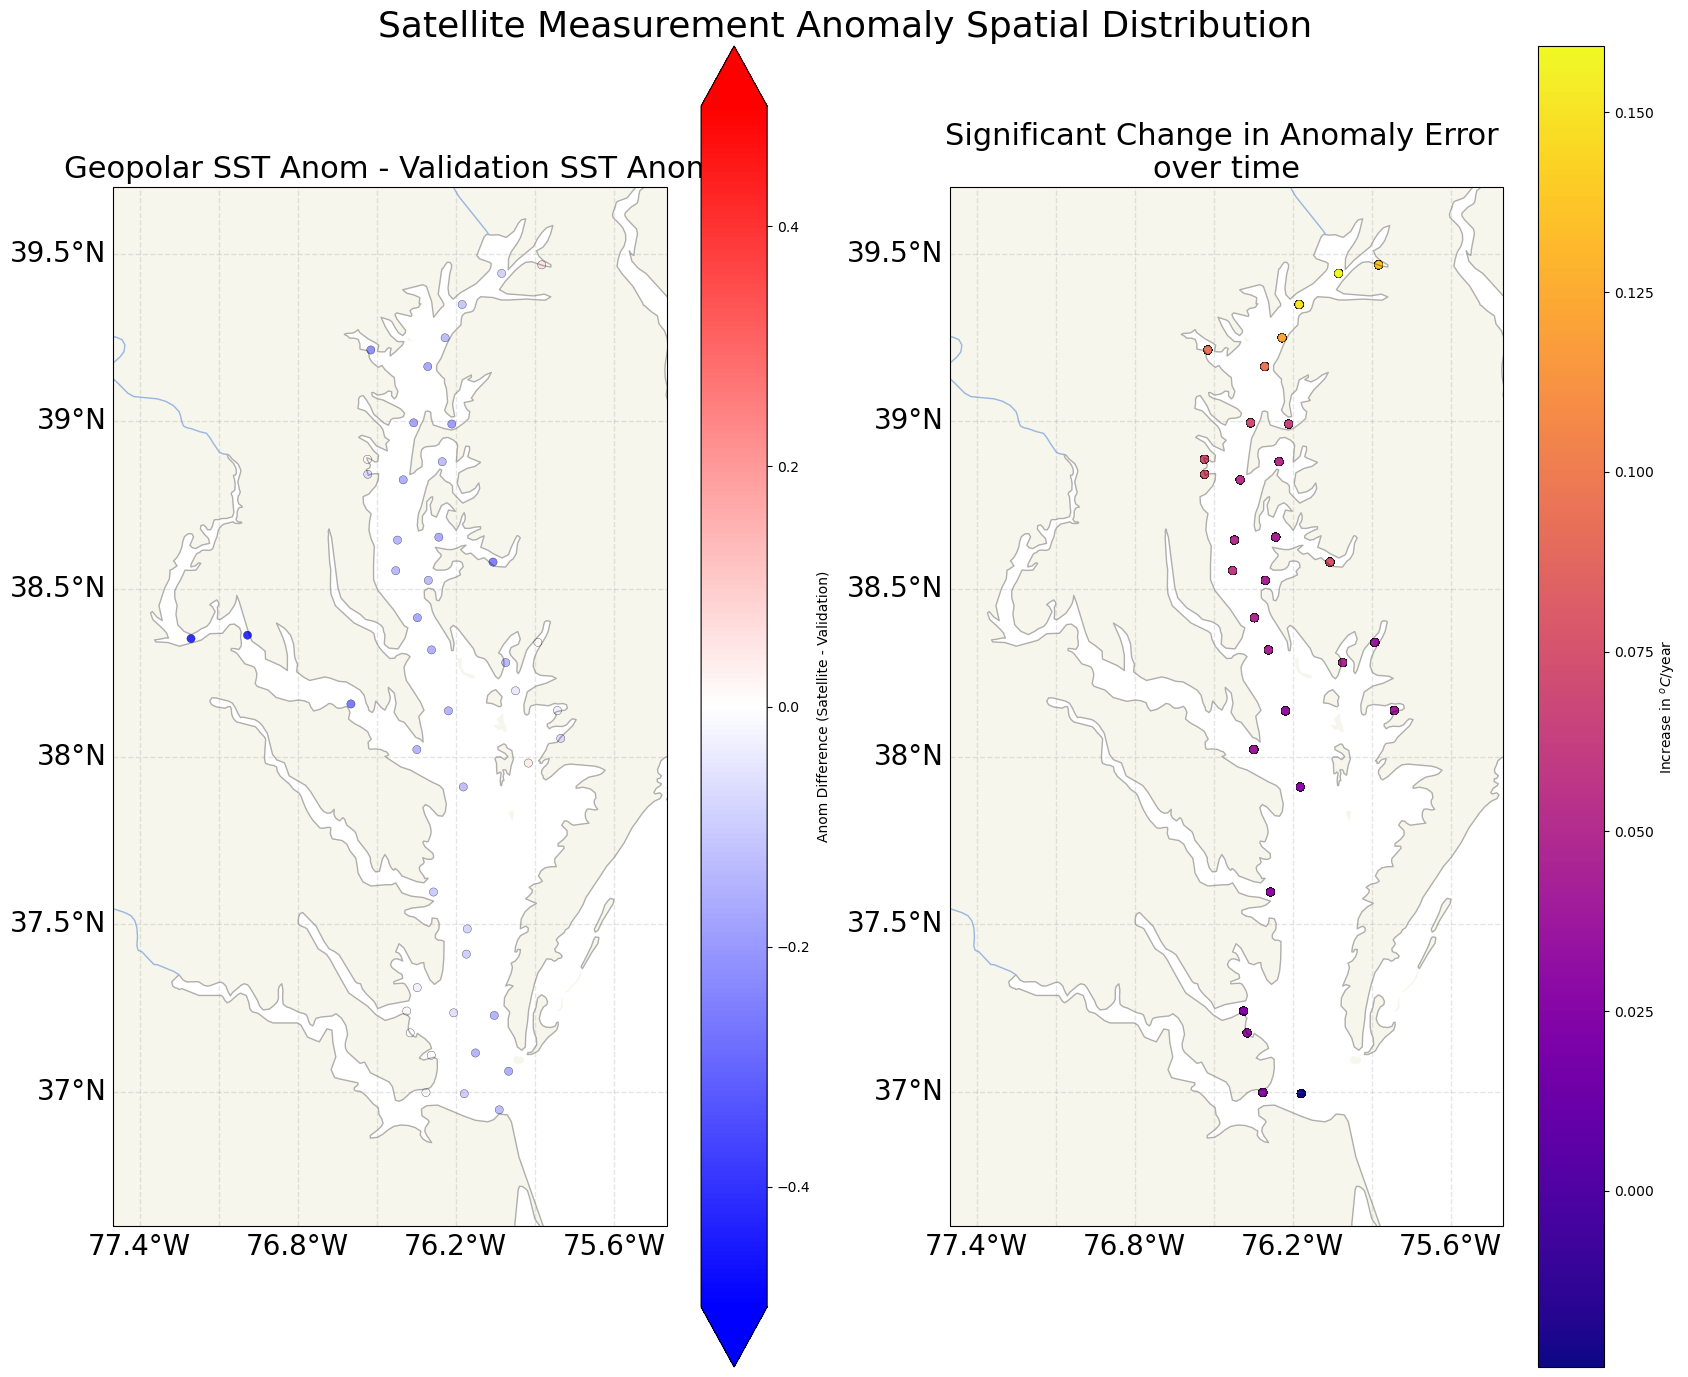

In [68]:
fig, axes = plt.subplots(1, 2, subplot_kw={'projection': ccrs.PlateCarree()})

fig.set_size_inches(17, 14)
# fig.tight_layout()
fig.suptitle('Satellite Measurement Anomaly Spatial Distribution', size=26)
# fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

# my_cmap = matplotlib.cm.get_cmap('viridis')
# my_cmap.set_bad('black')

for ax in axes.flatten():
    # Add background features
    ax.add_feature(cfeature.COASTLINE, alpha=0.3)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)
    # ax.coastlines()
    # Put a background image on for nice sea rendering.
    # ax.stock_img()

    ax.set_extent([-77.5, -75.4, 36.6, 39.7])

    # Add and format gridlines. Remove top and right labels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.2, linestyle='--')
    gl.top_labels, gl.right_labels = False, False
    gl.xlabel_style = {'size': 20}
    gl.ylabel_style = {'size': 20}

# Add mean error
temps_mean_gpd.plot(ax=axes[0], column='geopolar_diff', markersize=35, cmap='bwr', legend=True, 
                    legend_kwds={'label': "Anom Difference (Satellite - Validation)", 
                                 'extend': 'both'}, 
                    vmin=-0.5, vmax=0.5, edgecolor='black', linewidth=0.2)
axes[0].set_title('Geopolar SST Anom - Validation SST Anom', size=22)

# Add long term trend slope
# Can't get pandas to show nan values. Maybe set to 0 then change colormap?
stats_gpd.plot(ax=axes[1], column='slope', markersize=35, cmap='plasma',
                legend=True,
                    legend_kwds={'label': "Increase in $^oC$/year"}, 
                    edgecolor='black', linewidth=0.2)
axes[1].set_title('Significant Change in Anomaly Error \nover time', size=22)

plt.tight_layout()

# save
if SAVE_FIGS:
    plt.savefig(os.path.join(REPO_ROOT, 'figures', 'validation_analysis/map_distribution_statistics_shorter.png'), 
                dpi=400, bbox_inches='tight')

Walking through p values:

Question: Does the size of the anomaly value vary over time?
Hypothesis: ...

In [69]:
# wq_sst.groupby(['Latitude', 'Longitude']).apply(trend_calc)

## Hovm&#246;ller Plot for Seasonality of Error



In [70]:
def create_hovmoller_matrix(temps, satellite):
    temps = temps.set_index(pd.to_datetime(temps['SampleDate']))
    temps = temps.resample('M').mean()
    
    temps = temps[[satellite + '_diff']]
    
    temps['month'] = temps.index.month
    temps['year'] = temps.index.year
    
    matrix = temps.pivot(index='year', columns='month')
    
    # print(satellite, 'min / max', satellite, ':', matrix.min().min(), matrix.max().max())
    # print(satellite, 'mean / std', satellite, ':', matrix.mean().mean(), matrix.std().std())
    return matrix

In [71]:
wq_sst_gp[(wq_sst_gp.SampleDate.dt.month == 4) & (wq_sst_gp.SampleDate.dt.year == 2020)]

,MeasureAnomaly,Latitude,Longitude,SampleDate,geopolar_anom,mur_anom,geopolar_diff,mur_diff


In [72]:
(wq_sst_gp.geopolar_diff.isnull()).sum()

0

In [73]:
matrix_geop = create_hovmoller_matrix(wq_sst_gp, 'geopolar')
matrix_mur = create_hovmoller_matrix(wq_sst_mur, 'mur')

/var/folders/nb/y7dp0ct55_58hrhrhlz5vbkm0000gn/T/ipykernel_2700/64737636.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temps = temps.resample('M').mean()
/var/folders/nb/y7dp0ct55_58hrhrhlz5vbkm0000gn/T/ipykernel_2700/64737636.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temps = temps.resample('M').mean()


In [74]:
matrix_geop

geopolar_diff                                                    \
month            1         2         3         4         5         6    
year                                                                    
2003       0.365544  0.258378 -0.155379 -0.855345 -1.031313 -0.835952   
2004       0.639117 -0.300028 -1.343130 -0.808524 -2.695480 -0.419983   
2005      -1.115342 -0.855084 -0.115730 -0.281441 -1.212504 -1.870817   
2006      -0.808117 -0.294242 -0.173350 -0.206722 -1.254993 -0.801482   
2007      -0.680865 -0.167782 -1.425617  0.199677 -1.293682 -0.525674   
2008      -0.196874 -1.195071 -1.811189 -1.647241 -2.151328  0.028327   
2009       0.055824 -0.728764 -0.681324 -1.065346 -1.718456 -0.530442   
2010       0.807154  0.063791 -2.071162 -0.125193 -0.425423 -1.023625   
2011       1.056568  0.653934 -0.802015  0.366732  0.591000  0.555631   
2012      -0.456908 -0.115687  0.057655 -0.404190 -0.916904  0.973178   
2013      -0.345745 -0.336139 -0.379898 -0.435694  0.064507  0.907164   
2014       0.032988  0.001773 -0.111716 -0.754454  0.678358  1.167857   
2015      -0.077696 -0.058414  0.654400  1.652696  1.257533  0.930248   
2016       0.555277 -0.411345 -0.330352  0.384600  0.490016  0.621052   
2017       0.126856  0.089412 -0.989232  0.665707  1.260382  0.394797   
2018       0.240223 -0.564926 -0.637941 -0.711554  0.015801  1.257548   
2019       0.358483 -0.125333  0.146061  0.035063  0.559882  1.107329   
2020      -1.461185 -0.676305  1.360917       NaN -2.249674  0.855157   
2021      -0.193038  0.102643  0.076753  1.696004  0.966864  1.436848   
2022       0.620602 -0.095530  0.124128  0.152273  0.108204  1.082513   

                                                                   
month        7         8         9         10        11        12  
year                                                               
2003  -0.508587 -0.883491 -0.533274 -0.632764  0.214024  0.681114  
2004  -0.018477 -0.363956  0.122229 -1.077176 -0.862034 -1.301996  
2005  -1.006803 -0.532529 -0.981140  1.172443  0.257732  1.007577  
2006  -0.727144 -0.697727 -0.355479 -0.208255 -0.681852  0.454014  
2007  -0.828811 -0.121516  0.062549 -1.140035 -0.664181  0.492510  
2008   0.107910  0.203938 -0.310699  0.851779  1.188754  0.046232  
2009  -0.075019 -0.279722 -0.453937  1.787524  0.044922 -0.776127  
2010  -0.763530 -0.220765  0.478511 -0.170529 -0.262153  2.162376  
2011   0.085451 -0.021372 -0.114550 -0.981924  0.056456 -0.142630  
2012   0.262640 -0.029818  0.160563 -0.859050 -0.247019 -0.763564  
2013   0.076217  0.142279  0.164585 -0.790516  0.569818 -0.178562  
2014   0.470706  0.035363 -0.235768  0.404223  1.957449  0.119679  
2015   0.420365 -0.162989  0.042047 -0.086669  0.082683 -0.502205  
2016   0.143224  0.025879  0.158510 -0.296597 -0.103874  0.544488  
2017   0.417928  0.138662  0.207340  0.575111 -0.289583  0.773544  
2018   0.482786  0.016807  0.719461  0.561457  0.252738 -0.026850  
2019   0.740289  0.279652 -0.073660 -0.551499  0.575730 -0.903387  
2020   1.050079  0.227202  0.184158 -0.738607 -0.076958  0.368359  
2021   1.083884  0.211416 -0.582189 -1.493737 -0.696702 -1.200787  
2022   0.649528  0.280845 -0.746531 -1.191050 -0.020355 -1.225455

### Quantifying Long Term trend by month

In [75]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(range(20),
                                                                     matrix_geop.mean(axis=1))

print('Geopolar: slope', slope.round(3), 'deg C per year', 'intercept', intercept, 'r squared', r_value**2, 'p_value', p_value)

Geopolar: slope 0.04 deg C per year intercept -0.48917599981726356 r squared 0.5877981842997915 p_value 8.043954842394393e-05


In [76]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(range(20),
    matrix_mur.mean(axis=1))

print('MUR: slope', slope.round(3), 'deg C per year', 'intercept', intercept, 'r squared', r_value**2, 'p_value', p_value)

MUR: slope 0.067 deg C per year intercept -0.7491984554656141 r squared 0.5356404178614418 p_value 0.0002444903235884138


In [77]:
def linearregression(row):
    _, _, r_value, p_value, _ = scipy.stats.linregress(range(20), row)
    row['p_value'] = p_value
    # return pd.DataFrame({'p_value': p_value, 'other': 0})
    return p_value

In [78]:
def significant_slopes(row):
    slope, _, r_value, p_value, _ = scipy.stats.linregress(range(20), row)
    # if p_value > 0.05:
    #     slope = np.nan
    # return pd.DataFrame({'p_value': p_value, 'other': 0})
    return slope

In [79]:
geo_pvals = matrix_geop.apply(linearregression, axis=0)
geo_slope = matrix_geop.apply(significant_slopes, axis=0)

In [80]:
mur_pvals = matrix_mur.apply(linearregression, axis=0)
mur_slope = matrix_mur.apply(significant_slopes, axis=0)

In [81]:
geo_pvals.index = geo_pvals.index.droplevel(0)
mur_pvals.index = mur_pvals.index.droplevel(0)

geo_slope.index = geo_slope.index.droplevel(0)
mur_slope.index = mur_slope.index.droplevel(0)

In [82]:
all_pvals = pd.concat([geo_pvals, mur_pvals], axis=1, keys=['geopolar', 'mur'])
all_slopes = pd.concat([geo_slope, mur_slope], axis=1, keys=['geopolar', 'mur'])

In [83]:
geo_slope = pd.DataFrame(geo_slope)
geo_slope['significant'] = geo_slope > 0.05

In [84]:
geo_slope = geo_slope.rename({0: 'error_slope'}, axis=1)

In [85]:
geo_slope

,error_slope,significant
month,,
1,0.007395,False
2,0.008740,False
3,0.067316,True
4,NaN,False
5,0.121935,True
6,0.132508,True
7,0.087450,True
8,0.044895,False
9,0.014097,False


In [86]:
geo_pvals

month
1     0.779017
2     0.606735
3     0.030520
4          NaN
5     0.005930
6     0.000005
7     0.000002
8     0.000014
9     0.401242
10    0.341030
11    0.700898
12    0.164936
dtype: float64

### Ploting Temporal Trends

In [87]:
vmin, vmax = -2.5, 2.5
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [88]:
cmap = plt.cm.twilight
norm = matplotlib.colors.BoundaryNorm(range(1, 15), cmap.N)
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

In [89]:
# import matplotlib.patches as patches

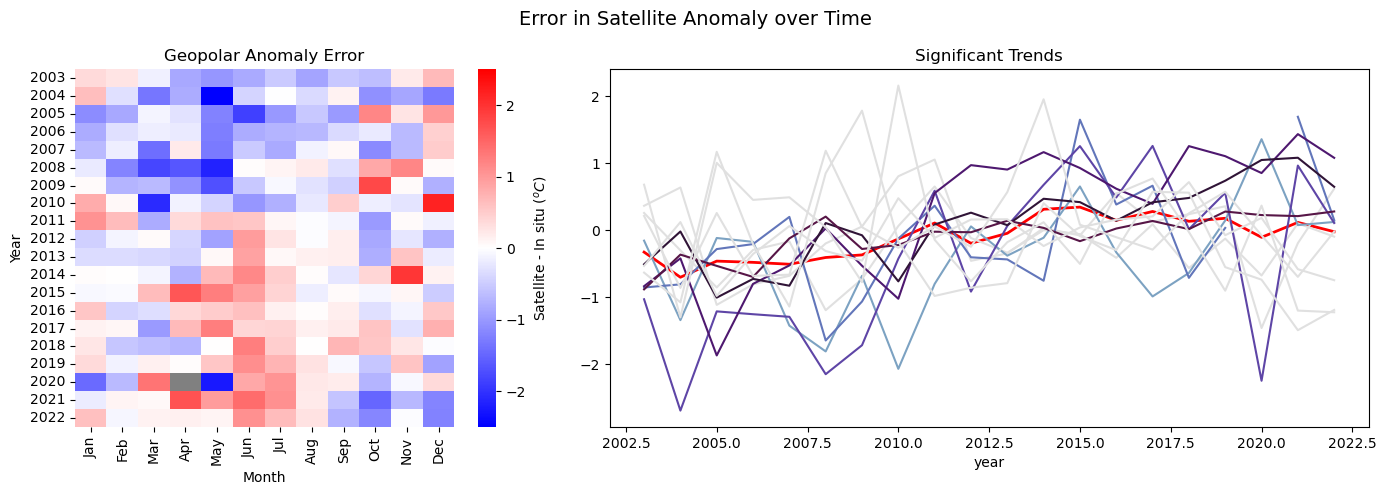

In [90]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={'width_ratios': [1, 1.6]})
fig.suptitle('Error in Satellite Anomaly over Time', size=14)

bwr_badgrey = plt.cm.get_cmap("bwr").copy()
bwr_badgrey.set_bad('grey')

sns.heatmap(matrix_geop, ax=ax1, cmap=bwr_badgrey, vmin=vmin, vmax=vmax,
            cbar_kws={'label': 'Satellite - In situ ($^oC$)'})
ax1.set_xticklabels(months, rotation=90)
ax1.set_xlabel('Month')
ax1.set_ylabel('Year')

# # Create a Rectangle patch
# rect = patches.Rectangle((3, 2021), 40, 1000, linewidth=10, edgecolor='black', facecolor='black')

# # Add the patch to the Axes
# ax1.add_patch(rect)

# Format the colorbar
cmap = plt.cm.twilight
norm = matplotlib.colors.BoundaryNorm(range(1, 15), cmap.N)
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
colors=[]
for i in range(12):
    if geo_pvals.iloc[i] > 0.05:
        # append light grey if the trend is not significant
        colors.append((0.878, 0.878, 0.878, 1))
    else:
        colors.append(sm.to_rgba(i+1))

matrix_geop.mean(axis=1).plot(ax=ax2, color='red', linewidth=2, label='mean')
matrix_geop.plot(ax=ax2, color=colors, legend=False)

ax1.set_title('Geopolar Anomaly Error')
ax2.set_title('Significant Trends')


plt.tight_layout()
if SAVE_FIGS:
    plt.savefig(os.path.join(REPO_ROOT, 'figures', 'validation_analysis/hovmoller_error_withmonths.png'), 
                dpi=350, bbox_inches='tight')

In [91]:
matrix_geop.min().min(), matrix_geop.max().max()

(-2.695480044040866, 2.1623756940813883)

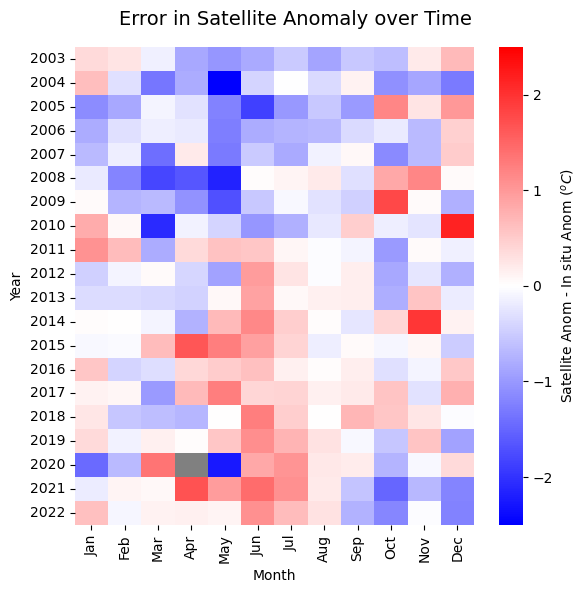

In [92]:
fig, ax = plt.subplots()
fig.set_size_inches(6, 6)
fig.suptitle('Error in Satellite Anomaly over Time', size=14)

bwr_badgrey = plt.cm.get_cmap("bwr").copy()
bwr_badgrey.set_bad('grey')

sns.heatmap(matrix_geop, ax=ax, cmap=bwr_badgrey, vmin=vmin, vmax=vmax,
            cbar_kws={'label': 'Satellite Anom - In situ Anom ($^oC$)'})
ax.set_xticklabels(months, rotation=90)
ax.set_xlabel('Month')
ax.set_ylabel('Year')

# # Create a Rectangle patch
# rect = patches.Rectangle((3, 2021), 40, 1000, linewidth=10, edgecolor='black', facecolor='black')

# # Add the patch to the Axes
# ax1.add_patch(rect)

# Format the colorbar
# cmap = plt.cm.twilight
# norm = matplotlib.colors.BoundaryNorm(range(1, 15), cmap.N)
# sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
# colors=[]
# for i in range(12):
#     if geo_pvals.iloc[i] > 0.05:
#         # append light grey if the trend is not significant
#         colors.append((0.878, 0.878, 0.878, 1))
#     else:
#         colors.append(sm.to_rgba(i+1))

matrix_geop.mean(axis=1).plot(ax=ax2, color='red', linewidth=2, label='mean')
# matrix_geop.plot(ax=ax2, color=colors, legend=False)

ax1.set_title('Geopolar Anomaly Error')
# ax2.set_title('Significant Trends')


plt.tight_layout()
if SAVE_FIGS:
    plt.savefig(os.path.join(REPO_ROOT, 'figures/validation_analysis/hovmoller_error.png'), 
                dpi=350, 
                bbox_inches='tight')

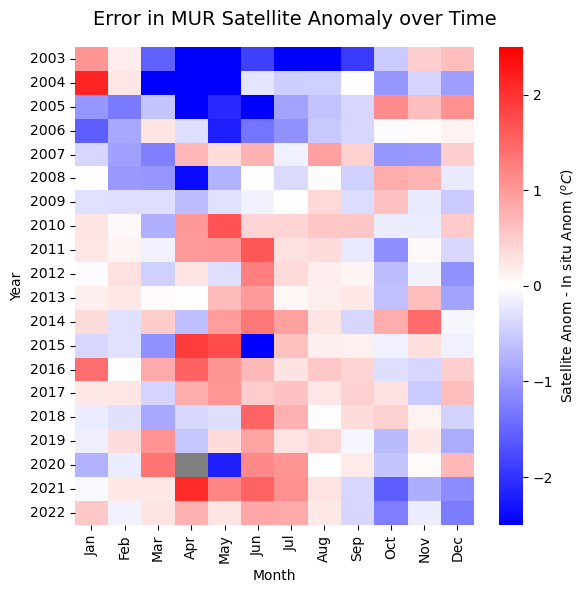

In [97]:
fig, ax = plt.subplots()
fig.set_size_inches(6, 6)
fig.suptitle('Error in MUR Satellite Anomaly over Time', size=14)

bwr_badgrey = plt.cm.get_cmap("bwr").copy()
bwr_badgrey.set_bad('grey')

sns.heatmap(matrix_mur, ax=ax, cmap=bwr_badgrey, vmin=vmin, vmax=vmax,
            cbar_kws={'label': 'Satellite Anom - In situ Anom ($^oC$)'})
ax.set_xticklabels(months, rotation=90)
ax.set_xlabel('Month')
ax.set_ylabel('Year')

# # Create a Rectangle patch
# rect = patches.Rectangle((3, 2021), 40, 1000, linewidth=10, edgecolor='black', facecolor='black')

# # Add the patch to the Axes
# ax1.add_patch(rect)

# Format the colorbar
# cmap = plt.cm.twilight
# norm = matplotlib.colors.BoundaryNorm(range(1, 15), cmap.N)
# sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
# colors=[]
# for i in range(12):
#     if geo_pvals.iloc[i] > 0.05:
#         # append light grey if the trend is not significant
#         colors.append((0.878, 0.878, 0.878, 1))
#     else:
#         colors.append(sm.to_rgba(i+1))

# matrix_mur.mean(axis=1).plot(ax=ax2, color='red', linewidth=2, label='mean')
# matrix_geop.plot(ax=ax2, color=colors, legend=False)

# ax2.set_title('Geopolar Anomaly Error')
# ax2.set_title('Significant Trends')

plt.tight_layout()
SAVE_FIGS = True
if SAVE_FIGS:
    plt.savefig(os.path.join(REPO_ROOT, 'figures/supplemental_material/mur_hovmoller_anomaly_error.png'), 
                dpi=350, 
                bbox_inches='tight')

In [93]:
# fig, ax = plt.subplots()
# fig.set_size_inches(6, 6)
# fig.suptitle('Error in Satellite Anomaly over Time', size=14)

# bwr_badgrey = plt.cm.get_cmap("bwr").copy()
# bwr_badgrey.set_bad('grey')

# sns.heatmap(matrix_geop, ax=ax, cmap=bwr_badgrey, vmin=vmin, vmax=vmax,
#             cbar_kws={'label': 'Satellite Anom - In situ Anom ($^oC$)'})
# ax.set_xticklabels(months, rotation=90)
# ax.set_xlabel('Month')
# ax.set_ylabel('Year')

# matrix_geop.mean(axis=1).plot(ax=ax2, color='red', linewidth=2, label='mean')
# # matrix_geop.plot(ax=ax2, color=colors, legend=False)

# ax1.set_title('Geopolar Anomaly Error')
# # ax2.set_title('Significant Trends')


# plt.tight_layout()
# if SAVE_FIGS:
#     plt.savefig(os.path.join(REPO_ROOT, 'figures/validation_analysis/hovmoller_error.png'), 
#                 dpi=350, 
#                 bbox_inches='tight')